# Optimizing a cognitive model

[![Open In
Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nengo/nengo-dl/blob/master/docs/examples/spa-retrieval.ipynb)

The purpose of this example is to illustrate how NengoDL can be used to optimize a more
complex cognitive model, involving the retrieval of information from highly structured
[semantic pointers](http://compneuro.uwaterloo.ca/research/spa.html). We will create a
network that takes a collection of information as input (encoded using semantic
pointers), and train it to retrieve some specific element from that collection.

In [1]:
%matplotlib inline

from urllib.request import urlretrieve

import matplotlib.pyplot as plt
import nengo
import nengo.spa as spa
import numpy as np
import tensorflow as tf

import nengo_dl

The first thing to do is define a function that produces random examples of structured
semantic pointers. Each example consists of a collection of role-filler pairs of the
following form:

$TRACE_0 = \sum_{j=0}^N Role_{0,j} \circledast Filler_{0,j}$

where terms like $Role$ refer to simpler semantic pointers (i.e., random vectors), the
$\circledast$ symbol denotes circular convolution, and the summation means vector
addition.  That is, we define different pieces of information consisting of Roles and
Fillers, and then we sum the information together in order to generate the full trace.
As an example of how this might look in practice, we could encode information about a
dog as

$DOG = COLOUR \circledast BROWN + LEGS \circledast FOUR + TEXTURE \circledast FURRY +
...$

The goal of the system is then to retrieve a cued piece of information from the semantic
pointer.  For example, if we gave the network the trace $DOG$ and the cue $COLOUR$ it
should output $BROWN$.

In [2]:
def get_data(n_items, pairs_per_item, vec_d, vocab_seed):
    # the vocabulary object will handle the creation of semantic
    # pointers for us
    rng = np.random.RandomState(vocab_seed)
    vocab = spa.Vocabulary(dimensions=vec_d, rng=rng, max_similarity=1)

    # initialize arrays of shape (n_inputs, n_steps, vec_d)
    traces = np.zeros((n_items, 1, vec_d))
    cues = np.zeros((n_items, 1, vec_d))
    targets = np.zeros((n_items, 1, vec_d))

    # iterate through all of the examples to be generated
    for n in range(n_items):
        role_names = [f"ROLE_{n}_{i}" for i in range(pairs_per_item)]
        filler_names = [f"FILLER_{n}_{i}" for i in range(pairs_per_item)]

        # create key for the 'trace' of bound pairs (i.e. a
        # structured semantic pointer)
        trace_key = "TRACE_" + str(n)
        trace_ptr = vocab.parse(
            "+".join(f"{x} * {y}" for x, y in zip(role_names, filler_names))
        )
        trace_ptr.normalize()
        vocab.add(trace_key, trace_ptr)

        # pick which element will be cued for retrieval
        cue_idx = rng.randint(pairs_per_item)

        # fill array elements correspond to this example
        traces[n, 0, :] = vocab[trace_key].v
        cues[n, 0, :] = vocab[f"ROLE_{n}_{cue_idx}"].v
        targets[n, 0, :] = vocab[f"FILLER_{n}_{cue_idx}"].v

    return traces, cues, targets, vocab

Next we'll define a Nengo model that retrieves cued items from structured semantic
pointers. So, for a given trace (e.g., $TRACE_0$) and cue (e.g., $Role_{0,0}$), the
correct output would be the corresponding filler ($Filler_{0,0}$). The model we'll build
will perform such retrieval by implementing a computation of the form:

$TRACE_0 \:\: \circledast \sim Role_{0,0} \approx Filler_{0,0}$

That is, convolving the trace with the inverse of the given cue will produce
(approximately) the associated filler. More details about the mathematics of how/why
this works can be found
[here](https://www.semanticscholar.org/paper/Holographic-reduced-representations-Plate/564427596799f7967c91934966cd3c6bd31cb06d).

We can create a model to perform this calculation by using the
`nengo.networks.CircularConvolution` network that comes with Nengo.

In [3]:
seed = 0
dims = 32
minibatch_size = 50
n_pairs = 2

with nengo.Network(seed=seed) as net:
    # use rectified linear neurons
    net.config[nengo.Ensemble].neuron_type = nengo.RectifiedLinear()
    net.config[nengo.Connection].synapse = None

    # provide a pointer and a cue as input to the network
    trace_inp = nengo.Node(np.zeros(dims))
    cue_inp = nengo.Node(np.zeros(dims))

    # create a convolution network to perform the computation
    # specified above
    cconv = nengo.networks.CircularConvolution(5, dims, invert_b=True)

    # connect the trace and cue inputs to the circular
    # convolution network
    nengo.Connection(trace_inp, cconv.input_a)
    nengo.Connection(cue_inp, cconv.input_b)

    # probe the output
    out = nengo.Probe(cconv.output)

In order to assess the retrieval accuracy of the model we need a metric for success.  In
this case we'll say that a cue has been successfully retrieved if the output vector is
more similar to the correct filler vector than it is to any of the other vectors in the
vocabulary.

In [4]:
def accuracy(output, vocab, targets, t_step=-1):
    # provide the probed output data, the vocab,
    # the target vectors, and the time step at which to evaluate

    # get output at the given time step
    output = output[:, t_step, :]

    # compute similarity between each output and vocab item
    sims = np.dot(vocab.vectors, output.T)
    idxs = np.argmax(sims, axis=0)

    # check that the output is most similar to the target
    acc = np.mean(np.all(vocab.vectors[idxs] == targets[:, 0], axis=1))

    return acc

Now we can run the model on some test data to check the baseline retrieval accuracy.
Since we used only a small number of neurons in the circular convolution network, we
should expect mediocre results.

In [5]:
# generate some test inputs
test_traces, test_cues, test_targets, test_vocab = get_data(
    minibatch_size, n_pairs, dims, vocab_seed=seed
)
test_inputs = {trace_inp: test_traces, cue_inp: test_cues}

# run the simulator for one time step to compute the network outputs
with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    sim.step(data=test_inputs)

print("Retrieval accuracy:", accuracy(sim.data[out], test_vocab, test_targets))

|                     Building network (0%)                    | ETA:  --:--:--

|##                    Building network (4%)                     | ETA: 0:00:01

|####                  Building network (6%)                     | ETA: 0:00:01

|######                Building network (9%)                     | ETA: 0:00:01

|########             Building network (12%)                     | ETA: 0:00:01

|#################    Building network (27%)                     | ETA: 0:00:00

|#####################Building network (34%)                     | ETA: 0:00:00

|#####################Building network (38%)                     | ETA: 0:00:00

|#####################Building network (41%)                     | ETA: 0:00:00

|#####################Building network (44%)                     | ETA: 0:00:00

|#####################Building network (47%)                     | ETA: 0:00:00

|#####################Building network (50%)                     | ETA: 0:00:00

|#####################Building network (52%)                     | ETA: 0:00:00

|#####################Building network (55%)                     | ETA: 0:00:00

|#####################Building network (58%)                     | ETA: 0:00:00

|#####################Building network (65%)                     | ETA: 0:00:00

|#####################Building network (78%)######               | ETA: 0:00:00

|#####################Building network (85%)###########          | ETA: 0:00:00

|#####################Building network (88%)#############        | ETA: 0:00:00

|#####################Building network (90%)###############      | ETA: 0:00:00

|#####################Building network (93%)################     | ETA: 0:00:00

|#####################Building network (96%)##################   | ETA: 0:00:00

Build finished in 0:00:01                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

| #            Optimizing graph: operator simplificaton               | 0:00:00

|  #                       Optimizing graph                           | 0:00:00

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

| #               Optimizing graph: creating signals                  | 0:00:00

|    #                     Optimizing graph                           | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|                         Constructing graph      #                   | 0:00:04

|                         Constructing graph           #              | 0:00:05

|                         Constructing graph            #             | 0:00:05

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|###           Constructing graph: build stage (5%)              | ETA: 0:00:01

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


|##############Constructing graph: build stage (70%)             | ETA: 0:00:00

|                         Constructing graph               #          | 0:00:05

Construction finished in 0:00:05                                               

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|###           Constructing graph: build stage (5%)              | ETA: 0:00:01

|##############Constructing graph: build stage (70%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

Retrieval accuracy: 0.06


These results indicate that the model is only rarely performing accurate retrieval,
which means that this network is not very capable of manipulating structured semantic
pointers in a useful way.

We can visualize the similarity of the output for one of the traces to get a sense of
what this accuracy looks like (the similarity to the correct output is shown in red).

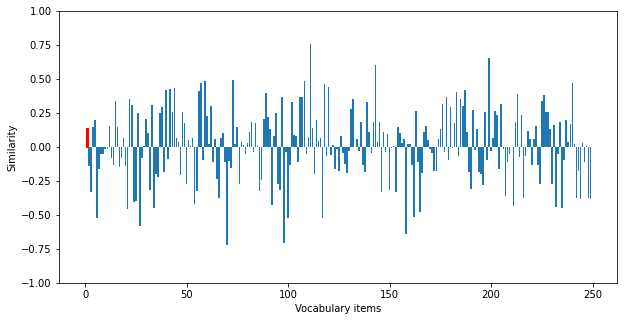

In [6]:
plt.figure(figsize=(10, 5))
bars = plt.bar(
    np.arange(len(test_vocab.vectors)), np.dot(test_vocab.vectors, sim.data[out][0, 0])
)
bars[
    np.where(np.all(test_vocab.vectors == test_targets[0, 0], axis=1))[0][0]
].set_color("r")
plt.ylim([-1, 1])
plt.xlabel("Vocabulary items")
plt.ylabel("Similarity")
plt.show()

We can see that the actual output is not particularly similar to this desired output,
which illustrates that the model is not performing accurate retrieval.

Now we'll train the network parameters to improve performance. We won't directly
optimize retrieval accuracy, but will instead minimize the mean squared error between
the model's output vectors and the vectors corresponding to the correct output items for
each input cue. We'll use a large number of training examples that are distinct from our
test data, so as to avoid explicitly fitting the model parameters to the test items.

To make this example run a bit quicker we'll download some pretrained model parameters
by default. Set `do_training=True` to train the model yourself.

In [7]:
sim = nengo_dl.Simulator(net, minibatch_size=minibatch_size, seed=seed)

do_training = False
if do_training:
    # create training data and data feeds
    train_traces, train_cues, train_targets, _ = get_data(
        n_items=5000, pairs_per_item=n_pairs, vec_d=dims, vocab_seed=seed + 1
    )

    # train the model
    sim.compile(optimizer=tf.optimizers.RMSprop(2e-3), loss=tf.losses.mse)
    sim.fit(
        {trace_inp: train_traces, cue_inp: train_cues}, {out: train_targets}, epochs=100
    )

    sim.save_params("./spa_retrieval_params")

else:
    # download pretrained parameters
    urlretrieve(
        "https://drive.google.com/uc?export=download&"
        "id=1KmroagQpaDAVbN-VnozqWVJw_1xjKxZj",
        "spa_retrieval_params.npz",
    )

    # load parameters
    sim.load_params("./spa_retrieval_params")

|                     Building network (0%)                    | ETA:  --:--:--

|##                    Building network (4%)                     | ETA: 0:00:01

|####                  Building network (7%)                     | ETA: 0:00:01

|######               Building network (10%)                     | ETA: 0:00:01

|########             Building network (12%)                     | ETA: 0:00:01

|##################   Building network (28%)                     | ETA: 0:00:00

|#####################Building network (34%)                     | ETA: 0:00:00

|#####################Building network (38%)                     | ETA: 0:00:00

|#####################Building network (40%)                     | ETA: 0:00:00

|#####################Building network (43%)                     | ETA: 0:00:00

|#####################Building network (45%)                     | ETA: 0:00:00

|#####################Building network (48%)                     | ETA: 0:00:00

|#####################Building network (51%)                     | ETA: 0:00:00

|#####################Building network (54%)                     | ETA: 0:00:00

|#####################Building network (57%)                     | ETA: 0:00:00

|#####################Building network (60%)                     | ETA: 0:00:00

|#####################Building network (74%)####                 | ETA: 0:00:00

|#####################Building network (81%)########             | ETA: 0:00:00

|#####################Building network (86%)############         | ETA: 0:00:00

|#####################Building network (88%)#############        | ETA: 0:00:00

|#####################Building network (91%)###############      | ETA: 0:00:00

|#####################Building network (93%)#################    | ETA: 0:00:00

|#####################Building network (96%)##################   | ETA: 0:00:00

Build finished in 0:00:01                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

| #            Optimizing graph: operator simplificaton               | 0:00:00

|  #           Optimizing graph: operator simplificaton               | 0:00:00

|  #                       Optimizing graph                           | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

|    #                     Optimizing graph                           | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|###           Constructing graph: build stage (5%)              | ETA: 0:00:01

|##############Constructing graph: build stage (70%)             | ETA: 0:00:00

|  #                      Constructing graph                          | 0:00:00

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

We can now recompute the network outputs using the trained model on the test data. We
can see that the retrieval accuracy is significantly improved. You can modify the
dimensionality of the vectors and the number of bound pairs in each trace to explore how
these variables influence the upper bound on retrieval accuracy.

In [8]:
sim.step(data=test_inputs)
print("Retrieval accuracy:", accuracy(sim.data[out], test_vocab, test_targets))
sim.close()

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|###           Constructing graph: build stage (5%)              | ETA: 0:00:01

|##############Constructing graph: build stage (70%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

Retrieval accuracy: 0.86


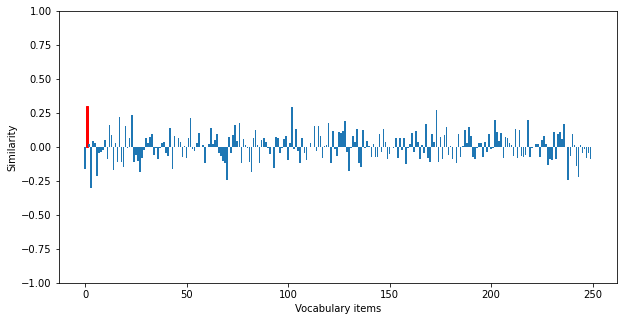

In [9]:
plt.figure(figsize=(10, 5))
bars = plt.bar(
    np.arange(len(test_vocab.vectors)), np.dot(test_vocab.vectors, sim.data[out][0, 0])
)
bars[
    np.where(np.all(test_vocab.vectors == test_targets[0, 0], axis=1))[0][0]
].set_color("r")
plt.ylim([-1, 1])
plt.xlabel("Vocabulary items")
plt.ylabel("Similarity")
plt.show()

Check out [this example](https://www.nengo.ai/nengo-dl/examples/spa-memory.html) for a
more complicated version of this task/model, in which a structured semantic pointer is
built up over time by binding together sequentially presented input items.